<a href="https://colab.research.google.com/github/fhrzn/advanced-nlp/blob/main/HW4_Affandy%20Fahrizain_J41332c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this homework you will understand the fine-tuning procedure and get acquainted with Huggingface Datasets library

In [4]:
# ! pip install datasets
! pip install git+https://github.com/huggingface/datasets.git
! pip install transformers

  Cloning https://github.com/huggingface/datasets.git to /tmp/pip-req-build-h8sws9z6
  Running command git clone -q https://github.com/huggingface/datasets.git /tmp/pip-req-build-h8sws9z6
     |████████████████████████████████| 212 kB 5.1 MB/s 
     |████████████████████████████████| 134 kB 26.1 MB/s 
     |████████████████████████████████| 1.1 MB 45.3 MB/s 
     |████████████████████████████████| 67 kB 5.2 MB/s 
     |████████████████████████████████| 127 kB 42.3 MB/s 
     |████████████████████████████████| 271 kB 52.9 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 144 kB 28.4 MB/s 
  Created wheel for datasets: filename=datasets-2.0.1.dev0-py3-none-any.whl size=326571 sha256=d66f9911c309d684a6b4d73a1b504fc0bf4dedf5a4c494a781b3876f18d6ca32
  Stored in directory: /tmp/pip-ephem-wheel-cache-4wb_k1bu/wheels/cc/33/c1/2cacc415b23189a83908e45db67381ba26175ef1e8aa9062aa
Successfully built datasets
  Attempting uninstall: urllib3
    Fou

For our goals we will use [Datasets](https://huggingface.co/docs/datasets/) library and take `yahoo_answers_topics` dataset - the task of this dataset is to divide documents on 10 topic categories. More detiled information can be found on the dataset [page](https://huggingface.co/datasets/viewer/).


In [5]:
from datasets import load_dataset

In [6]:
dataset = load_dataset('yahoo_answers_topics') # the result is a dataset dictionary of train and test splits in this case

Generating train split:   0%|          | 0/1400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Dataset yahoo_answers_topics downloaded and prepared to /root/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/0edb353eefe79d9245d7bd7cac5ae6af19530439da520d6dde1c206ee38f4439. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

# **Part 1: Fine-tuning the model** (15 points + 5 bonus)

In [7]:
from transformers import (ElectraTokenizer, ElectraForSequenceClassification,
                          get_scheduler, pipeline, ElectraForMaskedLM, ElectraModel)

import torch
from torch.utils.data import DataLoader
from datasets import load_metric

Fine-tuning procedure on the end task consists of adding additional layers on the top of the pre-trained model. The resulting model can be tuned fully (passing gradients through the all model) or partially.

**Task**: 
- load tokenizer and model
- look at the predictions of the model as-is before any fine-tuning


```
- Why don't you ask [MASK]?
- What is [MASK]
- Let's talk about [MASK] physics
```

- convert `best_answer` to the input tokens (supporting function for dataset is provided below) 

```
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
```

- define optimizer, sheduler (optional)
- fine-tune the model (write the training loop), plot the loss changes and measure results in terms of weighted F1 score
- get the masked word prediction (sample sentences above) on the fine-tuned model, why the results as they are and what should be done in order to change that (write down your answer)
- In case you will tune the training hyperparameters (and write down your results) you will get 5 bonus points.

**Tips**:
- The easiest way to get predictions is to use transformers `pipeline` function 
- Do not forget to set `num_labels` parameter, when initializing the model
- To convert data to batches use `DataLoader`
- Even the `small` version of Electra can be long to train, so you can take data sample (>= 5000 and set seed for reproducibility)
- You may want to try freezing (do not update the pretrained model weights) all the layers exept the ones for classification, in that case use:


```
for param in model.electra.parameters():
      param.requires_grad = False
```


In [8]:
MODEL_NAME = "google/electra-small-generator"
TOKENIZER_NAME = "google/electra-small-generator"

In [9]:
model_class, tokenizer_class = ElectraForSequenceClassification, ElectraTokenizer

model = model_class.from_pretrained(MODEL_NAME, num_labels=10)
tokenizer = tokenizer_class.from_pretrained(TOKENIZER_NAME)

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_predictions.LayerNorm.weight', 'generator_predictions.dense.bias', 'generator_predictions.dense.weight', 'generator_predictions.LayerNorm.bias', 'generator_lm_head.bias', 'generator_lm_head.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

## Prediction of Model As-Is

In [80]:
sentences = ["Why don't you ask [MASK]?", "What is [MASK]", "Let's talk about [MASK] physics"]

In [89]:
fill_mask = pipeline('fill-mask', MODEL_NAME, TOKENIZER_NAME)

In [90]:
for s in sentences:
  best_predict = fill_mask(s)
  token_str = sorted(best_predict, key=lambda x: x['score'], reverse=True)  
  print(s)
  for r in token_str:
    print(r)
  print()

Why don't you ask [MASK]?
{'score': 0.5342992544174194, 'token': 2033, 'token_str': 'me', 'sequence': "why don't you ask me?"}
{'score': 0.08196018636226654, 'token': 3980, 'token_str': 'questions', 'sequence': "why don't you ask questions?"}
{'score': 0.04395333677530289, 'token': 2068, 'token_str': 'them', 'sequence': "why don't you ask them?"}
{'score': 0.04017288610339165, 'token': 2339, 'token_str': 'why', 'sequence': "why don't you ask why?"}
{'score': 0.030024440959095955, 'token': 4426, 'token_str': 'yourself', 'sequence': "why don't you ask yourself?"}

What is [MASK]
{'score': 0.9262322783470154, 'token': 1029, 'token_str': '?', 'sequence': 'what is?'}
{'score': 0.05156780779361725, 'token': 1012, 'token_str': '.', 'sequence': 'what is.'}
{'score': 0.021510401740670204, 'token': 999, 'token_str': '!', 'sequence': 'what is!'}
{'score': 0.0001196492012240924, 'token': 1011, 'token_str': '-', 'sequence': 'what is -'}
{'score': 0.00010928419214906171, 'token': 1000, 'token_str': 

## Tokenize Best Answer

In [12]:
dataset['train'][100]

{'best_answer': "the enigmatic and poorly translated introduction to the American port of Zero Wing is equal parts confusing and hilarious. what in the world could a &quot;zig&quot; be? well, it would seem that the word &quot;zig,&quot; unfortunately, is not yet another perplexing term lost in translation. according to sites actually dedicated to reviewing the game in spite of its connections to the &quot;all your base are belong to us&quot; phenomena, the word &quot;zig&quot; is actually a made up name for the fighter plane you pilot throughout the game. think &quot;x-wing&quot; and you're on the right track.<br />\\n&quot;Take off every zig!!&quot; likely meant that every zig fighter needed to take off to battle the mysteriously robotic villian of the game, known only as &quot;Cats.&quot;",
 'id': 100,
 'question_content': 'You all remember that "All Your Base Are Belong to Us" internet phenomenon from early 2000.  I recently saw it again and read the game transcript.  What could the

In [13]:
sample_train = dataset['train'].shuffle(seed=42).select(range(12000))
sample_test = dataset['test'].shuffle(seed=42).select(range(2000))

In [14]:
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

sample_train = sample_train.map(tokenize_function, batched=True, remove_columns=['id', 'question_title', 'question_content', 'best_answer'])
sample_test = sample_test.map(tokenize_function, batched=True, remove_columns=['id', 'question_title', 'question_content', 'best_answer'])

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

### For Masked LM (Wrongly understand the main task 🤦‍♂️)

In [ ]:
# DON'T RUN! It's label creation for Masked LM
def create_label(examples):
    result = {k: v for k, v in examples.items()}
    result['labels'] = result['input_ids'].copy()
    return result

sample_train = sample_train.map(create_label, batched=True)
sample_test = sample_test.map(create_label, batched=True)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
tokenizer.decode(sample_test[0]['labels'])

'[CLS] d e f i n i t e l y!!! i happened across registry mechanic 5 in wal mart one day. i spent 60 dollars on it and would do it again in a heartbeat. this software is easy to use and extremely effective. g o f o r i t!!! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

#### Inserting [MASK] token at random

In [ ]:
def masking_token(examples, prob=0.15):
    '''
    [MASK]ing input function. Reference: https://www.youtube.com/watch?v=R6hcxMMOrPE
    '''
    sample_input = torch.tensor(examples['input_ids'])
    # sample_label = examples['labels']
    
    # create mask array
    rands = torch.rand(sample_input.shape)
    mask = (rands < prob) * (sample_input != 101) * \
            (sample_input != 102) * (sample_input != 0)

    # get indices
    indices = []
    for i in range(sample_input.shape[0]):
        indices.append(torch.flatten(mask[i].nonzero()).tolist())

    # apply mask
    for i in range(sample_input.shape[0]):
        sample_input[i, indices[i]] = 103
    
    # build result output
    result = {k: v for k, v in examples.items()}
    result['input_ids'] = sample_input.detach().tolist()   
    return result

In [ ]:
sample_train = sample_train.map(masking_token, batched=True)
sample_test = sample_test.map(masking_token, batched=True)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

## Training Loop

In [15]:
sample_train.set_format('torch')
sample_test.set_format('torch')

In [16]:
trainval = sample_train.train_test_split(train_size=10000, \
                                         test_size=2000, seed=42)
sample_train = trainval['train']
sample_val = trainval['test']

In [17]:
###################
#                 #
# hyperparameters #
#                 #
###################

BATCH_SIZE = 8
LEARNING_RATE = 5e-5
EPOCH = 10
WEIGHT_DECAY = 0
EARLY_STOP = 5

In [18]:
from torch.utils.data import DataLoader

train_loader = DataLoader(sample_train, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(sample_val, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(sample_test, shuffle=True, batch_size=BATCH_SIZE)

In [19]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# freeze pretrained weight. we only fine tune classification layer
for param in model.electra.parameters():
      param.requires_grad = False

model = model.to(device)

In [ ]:
from tqdm import tqdm
import numpy as np
from datasets import load_metric

def train(model, optimizer, train_loader, eval_loader, device, meter='f1', epoch=EPOCH, fname='ELECTRA-fine-tuning.pt'):

    history = {
        'train_loss': [],
        'train_f1': [],
        'val_loss': [],
        'val_f1': []
    }

    metric = load_metric(meter, average='weighted')
    minloss = np.inf
    early_stop = 0

    for e in range(epoch):
        
        # train
        trainloop = tqdm(train_loader, leave=True)
        trainloss = []
        trainf1 = []

        model.train()

        for batch in trainloop:
            # reset gradient
            optimizer.zero_grad()

            # move to gpu (if available)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['topic'].to(device)

            # forward
            outputs = model(input_ids, attention_mask=attention_mask,\
                            labels=labels)

            # loss
            loss = outputs.loss
            # record loss
            trainloss.append(loss.item())

            # f1
            logits = outputs.logits
            predict = torch.argmax(logits, dim=-1)
            # record f1        
            f1 = metric.compute(predictions=predict.flatten(), \
                                references=labels.flatten(), average='weighted')
            trainf1.append(f1['f1'])
            
            # backprop
            loss.backward()
            # update gradient
            optimizer.step()

            # progressbar meta
            trainloop.set_description(f'Epoch {e+1}/{epoch} | Training')
            trainloop.set_postfix({
                'loss': f'{loss.item():.4f}',
                'f1': f"{f1['f1']:.4f}"
            })

        history['train_loss'].append(np.mean(trainloss))
        history['train_f1'].append(np.mean(trainf1))

        # eval
        valloop = tqdm(eval_loader, leave=True)
        valloss = []
        valf1 = []

        model.eval()

        for batch in valloop:
            # move to gpu (if available)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['topic'].to(device)

            # forward
            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask,\
                                labels=labels)
                
            # loss
            loss = outputs.loss
            # record loss
            valloss.append(loss.item())

            # f1
            logits = outputs.logits
            predict = torch.argmax(logits, dim=-1)
            # record f1
            f1 = metric.compute(predictions=predict.flatten(), \
                                references=labels.flatten(), average='weighted')
            valf1.append(f1['f1'])
            
            # progressbar meta
            valloop.set_description(f'Epoch {e+1}/{epoch} | Validation')
            valloop.set_postfix({
                'loss': f'{loss.item():.4f}',
                'f1': f"{f1['f1']:.4f}"
            })

        # put back to train mode
        model.train()

        # print epoch result
        print(f'Epoch {e+1}/{epoch} | Train Loss: {np.mean(trainloss):.4f} | Val Loss: {np.mean(valloss):.4f}, F1: {np.mean(valf1)}')

        #  save checkpoint
        vloss = np.mean(valloss)
        if vloss < minloss:
            torch.save(model.state_dict(), f'/content/drive/MyDrive/Advanced NLP/{fname}')
            minloss = vloss
            early_stop = 0
        else:
            early_stop += 1
            print('Loss did not improved.')

        if early_stop >= 5:
            history['stopped_epoch'] = early_stop
            break
            
        history['val_loss'].append(np.mean(valloss))
        history['val_f1'].append(np.mean(valf1))

    return history, model

history, model = train(model, optimizer, train_loader, val_loader, device, epoch=EPOCH)

Epoch 1/10 | Training: 100%|██████████| 1250/1250 [03:08<00:00,  6.61it/s, loss=2.0501, f1=0.1875]
Epoch 1/10 | Validation: 100%|██████████| 250/250 [00:35<00:00,  7.13it/s, loss=1.9803, f1=0.5000]


Epoch 1/10 | Train Loss: 1.9224 | Val Loss: 1.8781, F1: 0.4170988095238095


Epoch 2/10 | Training: 100%|██████████| 1250/1250 [03:06<00:00,  6.69it/s, loss=1.3929, f1=0.7500]
Epoch 2/10 | Validation: 100%|██████████| 250/250 [00:34<00:00,  7.15it/s, loss=1.4905, f1=0.8000]


Epoch 2/10 | Train Loss: 1.8912 | Val Loss: 1.8465, F1: 0.4164892857142856


Epoch 3/10 | Training: 100%|██████████| 1250/1250 [03:07<00:00,  6.68it/s, loss=1.9595, f1=0.0833]
Epoch 3/10 | Validation: 100%|██████████| 250/250 [00:35<00:00,  7.12it/s, loss=1.6257, f1=0.5833]


Epoch 3/10 | Train Loss: 1.8517 | Val Loss: 1.8053, F1: 0.44778214285714285


Epoch 4/10 | Training: 100%|██████████| 1250/1250 [03:07<00:00,  6.65it/s, loss=1.8960, f1=0.2500]
Epoch 4/10 | Validation: 100%|██████████| 250/250 [00:34<00:00,  7.20it/s, loss=1.8651, f1=0.2083]


Epoch 4/10 | Train Loss: 1.8311 | Val Loss: 1.7719, F1: 0.4621849206349206


Epoch 5/10 | Training: 100%|██████████| 1250/1250 [03:06<00:00,  6.69it/s, loss=1.9342, f1=0.6167]
Epoch 5/10 | Validation: 100%|██████████| 250/250 [00:34<00:00,  7.20it/s, loss=1.9343, f1=0.4667]


Epoch 5/10 | Train Loss: 1.8188 | Val Loss: 1.7530, F1: 0.458925


Epoch 6/10 | Training: 100%|██████████| 1250/1250 [03:07<00:00,  6.67it/s, loss=1.4113, f1=0.4583]
Epoch 6/10 | Validation: 100%|██████████| 250/250 [00:34<00:00,  7.17it/s, loss=2.0470, f1=0.0000]


Epoch 6/10 | Train Loss: 1.7902 | Val Loss: 1.7471, F1: 0.4410761904761904


Epoch 7/10 | Training: 100%|██████████| 1250/1250 [03:06<00:00,  6.69it/s, loss=1.4766, f1=0.4750]
Epoch 7/10 | Validation: 100%|██████████| 250/250 [00:34<00:00,  7.19it/s, loss=1.9584, f1=0.3333]


Epoch 7/10 | Train Loss: 1.7886 | Val Loss: 1.7310, F1: 0.47324880952380954


Epoch 8/10 | Training: 100%|██████████| 1250/1250 [03:06<00:00,  6.71it/s, loss=1.8596, f1=0.2917]
Epoch 8/10 | Validation: 100%|██████████| 250/250 [00:34<00:00,  7.20it/s, loss=1.8903, f1=0.4375]


Epoch 8/10 | Train Loss: 1.7769 | Val Loss: 1.6953, F1: 0.4817928571428571


Epoch 9/10 | Training: 100%|██████████| 1250/1250 [03:06<00:00,  6.69it/s, loss=1.6433, f1=0.4167]
Epoch 9/10 | Validation: 100%|██████████| 250/250 [00:34<00:00,  7.21it/s, loss=1.4197, f1=0.6250]


Epoch 9/10 | Train Loss: 1.7670 | Val Loss: 1.6867, F1: 0.46908134920634914


Epoch 10/10 | Training: 100%|██████████| 1250/1250 [03:06<00:00,  6.70it/s, loss=2.2308, f1=0.3333]
Epoch 10/10 | Validation: 100%|██████████| 250/250 [00:34<00:00,  7.21it/s, loss=1.9648, f1=0.3750]


Epoch 10/10 | Train Loss: 1.7557 | Val Loss: 1.6808, F1: 0.46494087301587295


### Plot Loss

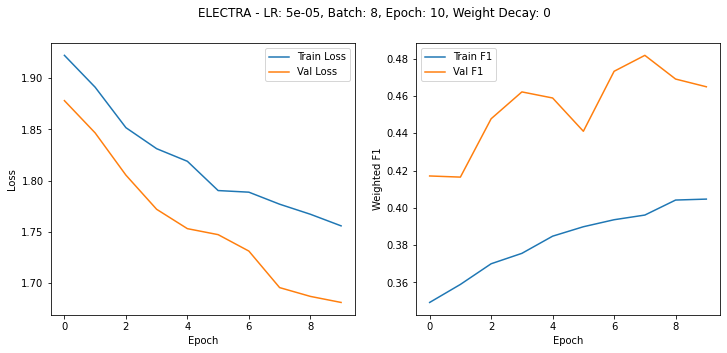

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(lr, batch, epoch, weight_decay, es, history):
    title = f'ELECTRA - LR: {lr}, Batch: {batch}, Epoch: {epoch}, Weight Decay: {weight_decay}'
    if 'stopped_epoch' in history and history['stopped_epoch'] >= 5:
        title += f'ES: {es}'

    f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    ax1.plot(list(range(epoch)), history['train_loss'], label='Train Loss')
    ax1.plot(list(range(epoch)), history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(list(range(epoch)), history['train_f1'], label='Train F1')
    ax2.plot(list(range(epoch)), history['val_f1'], label='Val F1')
    ax2.legend()
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Weighted F1')
    f.suptitle(title)
    plt.show()
    f.savefig(f'/content/drive/MyDrive/Advanced NLP/plots/{title}.png')

plot_loss(LEARNING_RATE, BATCH_SIZE, EPOCH, WEIGHT_DECAY, EARLY_STOP, history)

## Testing

In [ ]:
def testing(model, test_loader, device, meter='f1'):

    test_loop = tqdm(test_loader, leave=True)
    test_loss = []
    test_f1 = []

    metric = load_metric(meter, average='weighted')

    model.eval()

    for batch in test_loop:
        # move to gpu (if available)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['topic'].to(device)

        # forward
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask,\
                            labels=labels)
            
        # loss
        loss = outputs.loss
        # record loss
        test_loss.append(loss.item())

        # f1
        logits = outputs.logits
        predict = torch.argmax(logits, dim=-1)
        # record f1
        f1 = metric.compute(predictions=predict.flatten(), \
                            references=labels.flatten(), average='weighted')
        test_f1.append(f1['f1'])
        
        # progressbar meta
        test_loop.set_description(f'Testing')
        test_loop.set_postfix({
            'loss': f'{loss.item():.4f}',
            'f1': f"{f1['f1']:.4f}"
        })

    result = {
        'loss': np.mean(test_loss),
        'f1': np.mean(test_f1)
    }

    # print epoch result
    print()
    print(f'Test Loss: {result["loss"]:.4f}, F1: {result["f1"]:.4f}')

    return result

result = testing(model, test_loader, device)

Testing: 100%|██████████| 250/250 [00:36<00:00,  6.78it/s, loss=1.5083, f1=0.5750]


Test Loss: 1.6789, F1: 0.4549


## Tuning Hyperparameters

In [66]:
# load initial pretrained model on every change
model = model_class.from_pretrained(MODEL_NAME, num_labels=10)
# freeze pretrained weight. we only fine tune classification layer
for param in model.electra.parameters():
    param.requires_grad = False

model = model.to(device)

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_predictions.LayerNorm.weight', 'generator_predictions.dense.bias', 'generator_predictions.dense.weight', 'generator_predictions.LayerNorm.bias', 'generator_lm_head.bias', 'generator_lm_head.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

Tuned Hyperparameters:
- Batch Size = 32
- Learning Rate = 5e-4
- Epoch = 15
- Weight Decay = 0.0001

In [67]:
BATCH_SIZE = 32
LEARNING_RATE = 5e-4
EPOCH = 15
WEIGHT_DECAY = 0.0001
EARLY_STOP = 5

In [68]:
train_loader = DataLoader(sample_train, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(sample_val, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(sample_test, shuffle=True, batch_size=BATCH_SIZE)

In [69]:
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# freeze pretrained weight. we only fine tune classification layer
for param in model.electra.parameters():
      param.requires_grad = False

model = model.to(device)

Epoch 1/15 | Training: 100%|██████████| 313/313 [02:39<00:00,  1.97it/s, loss=2.0399, f1=0.1098]
Epoch 1/15 | Validation: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s, loss=2.1193, f1=0.4104]


Epoch 1/15 | Train Loss: 2.1721 | Val Loss: 1.9689, F1: 0.3331710811965907


Epoch 2/15 | Training: 100%|██████████| 313/313 [02:38<00:00,  1.97it/s, loss=1.5304, f1=0.3958]
Epoch 2/15 | Validation: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s, loss=1.7433, f1=0.4896]


Epoch 2/15 | Train Loss: 1.9062 | Val Loss: 1.7884, F1: 0.4163281239307702


Epoch 3/15 | Training: 100%|██████████| 313/313 [02:38<00:00,  1.98it/s, loss=1.7364, f1=0.2271]
Epoch 3/15 | Validation: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s, loss=1.6992, f1=0.3979]


Epoch 3/15 | Train Loss: 1.8103 | Val Loss: 1.7348, F1: 0.41428735201839845


Epoch 4/15 | Training: 100%|██████████| 313/313 [02:38<00:00,  1.97it/s, loss=2.1364, f1=0.2958]
Epoch 4/15 | Validation: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s, loss=1.7273, f1=0.3667]


Epoch 4/15 | Train Loss: 1.7852 | Val Loss: 1.7052, F1: 0.4456178865601059


Epoch 5/15 | Training: 100%|██████████| 313/313 [02:38<00:00,  1.98it/s, loss=1.7695, f1=0.3506]
Epoch 5/15 | Validation: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s, loss=1.9144, f1=0.4313]


Epoch 5/15 | Train Loss: 1.7590 | Val Loss: 1.6410, F1: 0.4611837773668131


Epoch 6/15 | Training: 100%|██████████| 313/313 [02:38<00:00,  1.98it/s, loss=1.8508, f1=0.3063]
Epoch 6/15 | Validation: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s, loss=1.5270, f1=0.4725]


Epoch 6/15 | Train Loss: 1.7494 | Val Loss: 1.6450, F1: 0.47824896831662367
Loss did not improved.


Epoch 7/15 | Training: 100%|██████████| 313/313 [02:38<00:00,  1.98it/s, loss=1.7527, f1=0.3342]
Epoch 7/15 | Validation: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s, loss=1.7956, f1=0.3167]


Epoch 7/15 | Train Loss: 1.7368 | Val Loss: 1.6599, F1: 0.4479137032297276
Loss did not improved.


Epoch 8/15 | Training: 100%|██████████| 313/313 [02:37<00:00,  1.98it/s, loss=1.5522, f1=0.5396]
Epoch 8/15 | Validation: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s, loss=1.4181, f1=0.5518]


Epoch 8/15 | Train Loss: 1.7131 | Val Loss: 1.6352, F1: 0.4906245787942217


Epoch 9/15 | Training: 100%|██████████| 313/313 [02:38<00:00,  1.97it/s, loss=2.0512, f1=0.1562]
Epoch 9/15 | Validation: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s, loss=1.4600, f1=0.5536]


Epoch 9/15 | Train Loss: 1.7164 | Val Loss: 1.6149, F1: 0.4763162446570184


Epoch 10/15 | Training: 100%|██████████| 313/313 [02:38<00:00,  1.97it/s, loss=1.4178, f1=0.4318]
Epoch 10/15 | Validation: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s, loss=1.6500, f1=0.4330]


Epoch 10/15 | Train Loss: 1.7170 | Val Loss: 1.6139, F1: 0.4837740981449287


Epoch 11/15 | Training: 100%|██████████| 313/313 [02:38<00:00,  1.97it/s, loss=1.6720, f1=0.4217]
Epoch 11/15 | Validation: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s, loss=1.9129, f1=0.3625]


Epoch 11/15 | Train Loss: 1.7070 | Val Loss: 1.5922, F1: 0.5132703333049096


Epoch 12/15 | Training: 100%|██████████| 313/313 [02:38<00:00,  1.98it/s, loss=2.3100, f1=0.1458]
Epoch 12/15 | Validation: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s, loss=1.5280, f1=0.4958]


Epoch 12/15 | Train Loss: 1.6893 | Val Loss: 1.6000, F1: 0.48675402885410896
Loss did not improved.


Epoch 13/15 | Training: 100%|██████████| 313/313 [02:38<00:00,  1.97it/s, loss=2.1689, f1=0.2196]
Epoch 13/15 | Validation: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s, loss=0.9337, f1=0.8708]


Epoch 13/15 | Train Loss: 1.6840 | Val Loss: 1.5570, F1: 0.506604608328357


Epoch 14/15 | Training: 100%|██████████| 313/313 [02:38<00:00,  1.98it/s, loss=1.5944, f1=0.5116]
Epoch 14/15 | Validation: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s, loss=1.7186, f1=0.5637]


Epoch 14/15 | Train Loss: 1.6861 | Val Loss: 1.5831, F1: 0.494912593857797
Loss did not improved.


Epoch 15/15 | Training: 100%|██████████| 313/313 [02:37<00:00,  1.99it/s, loss=1.5835, f1=0.4542]
Epoch 15/15 | Validation: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s, loss=1.7891, f1=0.4003]


Epoch 15/15 | Train Loss: 1.6931 | Val Loss: 1.5786, F1: 0.5058416423743806
Loss did not improved.


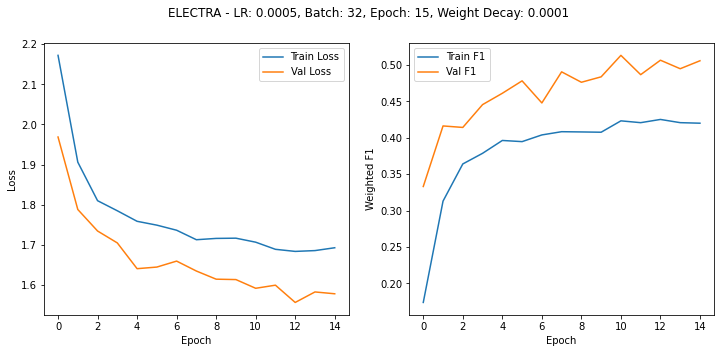

Testing: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s, loss=1.7822, f1=0.4000]


Test Loss: 1.5828, F1: 0.4999


In [70]:
fname = f'ELECTRA_B{BATCH_SIZE}_LR{LEARNING_RATE}_EP{EPOCH}_WD{WEIGHT_DECAY}.pt'
# training
history, model = train(model, optimizer, train_loader, val_loader, device, epoch=EPOCH, fname=fname)
# save plot loss
plot_loss(LEARNING_RATE, BATCH_SIZE, EPOCH, WEIGHT_DECAY, EARLY_STOP, history)
# testing
result = testing(model, test_loader, device)

Weighted F1 improved 0.04 from 0.45~

In [72]:
# save pretrained for predict masked word later
model.save_pretrained(fname)

## Get Masked Word Predictions

In [84]:
masked_model = ElectraForMaskedLM.from_pretrained(fname)

Some weights of the model checkpoint at ELECTRA_B32_LR0.0005_EP15_WD0.0001.pt were not used when initializing ElectraForMaskedLM: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
- This IS expected if you are initializing ElectraForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at ELECTRA_B32_LR0.0005_EP15_WD0.0001.pt and are newly initialized: ['generator_predictions.LayerNorm.weight', 'generator_predictions.dense.bias', 'generator_predictions.dense.weight', 'generator_prediction

In [85]:
fill_mask = pipeline('fill-mask', model=masked_model, tokenizer=tokenizer)

In [88]:
for s in sentences:
  best_predict = fill_mask(s)
  token_str = sorted(best_predict, key=lambda x: x['score'], reverse=True)  
  print(s)
  for r in token_str:
    print(r)
  print()

Why don't you ask [MASK]?
{'score': 0.00029102375265210867, 'token': 6524, 'token_str': 'r a r e l y', 'sequence': "why don't you ask rarely?"}
{'score': 0.0002746075624600053, 'token': 5681, 'token_str': 'o c c a s i o n a l l y', 'sequence': "why don't you ask occasionally?"}
{'score': 0.00025754180387593806, 'token': 2196, 'token_str': 'n e v e r', 'sequence': "why don't you ask never?"}
{'score': 0.00024983621551655233, 'token': 14274, 'token_str': 's u t h e r l a n d', 'sequence': "why don't you ask sutherland?"}
{'score': 0.0002475581713952124, 'token': 11738, 'token_str': 'f a n g s', 'sequence': "why don't you ask fangs?"}

What is [MASK]
{'score': 0.00032895986805669963, 'token': 1631, 'token_str': 'ⱼ', 'sequence': 'what is ⱼ'}
{'score': 0.000274607737082988, 'token': 26835, 'token_str': 'p a t h o g e n', 'sequence': 'what is pathogen'}
{'score': 0.00027091498486697674, 'token': 26641, 'token_str': 'o v e r d o s e', 'sequence': 'what is overdose'}
{'score': 0.00026976031949